## Load libraries and data

In [1]:
# !pip install transformers datasets
#!pip install tensorflow_datasets

In [2]:
import tensorflow as tf 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import transformers
import tensorflow_datasets as tfds 
from tensorflow.keras import layers 

2023-12-04 11:29:20.455649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# load data 
thumbnail_csv = pd.read_csv("./train.csv")

In [4]:
# count files 
import os

count = 0
for _, _, files_list in os.walk('./train_thumbnails/'):
    count += len(files_list)
print('file count:', count)

file count: 722


In [5]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = thumbnail_csv["label"].unique().tolist()
labels_list = thumbnail_csv["label"].tolist()

In [6]:
# # split images into subfolders :RUN ONCE
# import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [7]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.


Using 573 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.
Using 143 files for validation.


## Data visualization

In [9]:
# image batch 
image_batch, labels_batch = next(train_dataset.as_numpy_iterator())
print(image_batch.shape)
print(labels_batch.shape)


(32, 224, 224, 3)
(32,)


In [10]:
import tqdm as tqdm
import matplotlib.pyplot as plt 
class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(4):
#     # print(class_names[labels[i]])
#     ax = plt.subplot(2, 2, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [11]:
# split data
from datasets import load_dataset
dataset = (load_dataset("./train_thumbnails",split = "train")
          .train_test_split(test_size=0.2)
)
dataset

Resolving data files: 100%|██████████| 716/716 [00:00<00:00, 278298.74it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 572
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 144
    })
})

In [12]:
# image0 = dataset["train"]["image"][0]
# image0

In [13]:
class_names[dataset["train"]["label"][0]]

'EC'

In [14]:
# turn label into indices and vice-versa dict
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [15]:
id2label[str(1)]

'EC'

## Preprocessing

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

size = IMG_SIZE

In [17]:
# train data augmentation layer 
train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)



In [18]:
# validation data augmentation
val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [19]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [20]:
dataset["train"].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

In [21]:
from transformers import TFAutoModelForImageClassification, AutoImageProcessor, TFResNetModel

# image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")



In [22]:
# create batch of example
from transformers import DefaultDataCollator 

data_collator = DefaultDataCollator(return_tensors="tf")

In [23]:
# !pip install evaluate
import evaluate

accuracy = evaluate.load("accuracy")

In [24]:
# compue metrics func 
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Transformers 

In [25]:
# training HP
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(dataset["train"]) 
# num_train_steps = len(dataset["train"]) * num_epochs
# learning_rate = 3e-5
learning_rate = 1e-6
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [26]:
# load a ViT 
from transformers import TFAutoModelForImageClassification
checkpoint =  "google/vit-base-patch16-224-in21k"
# checkpoint = "microsoft/resnet-18",
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns="pixel_values", 
    label_cols="label", 
    shuffle=True, 
    batch_size=batch_size, 
    collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = dataset["test"].to_tf_dataset(
    columns="pixel_values", 
    label_cols="label", 
    shuffle=True,
    batch_size=batch_size, 
    collate_fn=data_collator
)

In [28]:
# configure the model to run 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# loss function 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer,
               loss=loss,
               metrics = "accuracy")

In [29]:
history = model.fit(tf_train_dataset, 
        validation_data=tf_eval_dataset,
        epochs=num_epochs)

Epoch 1/5
36/36 [==============================] - 871s 23s/step - loss: 8.0460 - accuracy: 0.1486 - val_loss: 9.2335 - val_accuracy: 0.1319
Epoch 2/5
36/36 [==============================] - 1118s 31s/step - loss: 7.6716 - accuracy: 0.1556 - val_loss: 9.0009 - val_accuracy: 0.1389
Epoch 3/5
36/36 [==============================] - 1095s 30s/step - loss: 7.4651 - accuracy: 0.1469 - val_loss: 8.6398 - val_accuracy: 0.1458
Epoch 4/5
36/36 [==============================] - 1130s 31s/step - loss: 7.4490 - accuracy: 0.1871 - val_loss: 8.5488 - val_accuracy: 0.1597
Epoch 5/5
36/36 [==============================] - 1386s 38s/step - loss: 6.7310 - accuracy: 0.1731 - val_loss: 8.1772 - val_accuracy: 0.1597


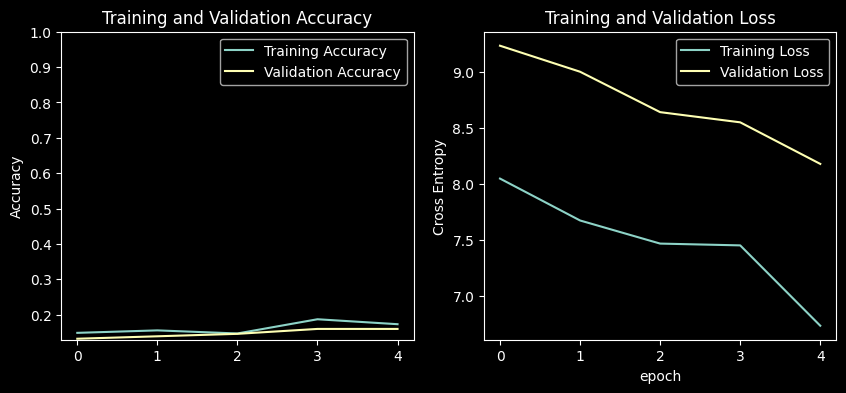

In [30]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

===

In [31]:
os.system('say "end of file"')

0